In [1]:
%%capture
!git clone https://github.com/hila-chefer/Transformer-Explainability.git Transformer_Explainability

In [2]:
%%capture
!pip install timm torchsummary tqdm einops

In [3]:
import os
import cv2
import tarfile
import numpy as np
import pandas as pd
from math import ceil
from time import time
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam, SGD
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [4]:
os.chdir(f'./Transformer_Explainability')
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP

In [5]:
np.random.seed(42)
torch.manual_seed(42)

## Setting up the GPU/CPU
will depend on the selected runtime for colab

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Extracting images to local storage

!rm -r /content/Dataset

my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/Dataset.tar.xz')
my_tar.extractall()
my_tar.close()

my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/data_bordered.tar.xz')
my_tar.extractall()
my_tar.close()

# Image path list

In [7]:
original_image_path = '/content/Transformer_Explainability/Dataset/1.training/1.training'
cutmix_image_path = '/content/Transformer_Explainability/Dataset/cutmix_augmentation'
constant_image_path = '/content/Transformer_Explainability/data_border_constant'
reflect_image_path = '/content/Transformer_Explainability/data_border_reflect'

In [8]:
image_path_list = []

In [9]:
def img_list(data_path):
  # getting list of all the images
  images = os.listdir(data_path)
  #exc_list = ['[1, 1, 0]', '[1, 0, 1]', '[0, 1, 1]', '[1, 1, 1]']
  # setting the flag based on the image path
  '''
  if path == orig_image_path:
    flag = 0
  else:
    flag = 1
  '''
  # don't need the flag, just resize all the images while loading to (224, 224)

  # adding to the image_path_list
  for i in images:
    # adding the image path, flag and the label
    #image_path_list[0].append([path + '/' + str(i), flag, list(map(int, i[-13:-4].strip('][').split(', ')))])
    #print(list(map(int, i[-13:-4].strip('][').split(', '))))
    if 'DS_S' in str(i):
      continue
    image_path_list.append([data_path + '/' + str(i), list(map(int, i[-13:-4].strip('][').split(', ')))])

In [10]:
# loading image paths
img_list(original_image_path)
img_list(cutmix_image_path)
img_list(constant_image_path)
img_list(reflect_image_path)

In [11]:
np.random.shuffle(image_path_list)

image_path_list = [x for x in image_path_list if ('[1, 0, 0]' in x[0]) or\
                                                 ('[0, 1, 0]' in x[0]) or\
                                                 ('[0, 0, 1]' in x[0])]

In [12]:
len(image_path_list)

36273

## Creating the dataset class

In [13]:
# Creating the dataset class for the data

class LUAD(Dataset):
  """Lung Adenocarcinoma Histopathological images."""
  
  def __init__(self, image_list, transform = None):
    
    """
      Args:
        image_list: csv/list/numpy array containing image paths, flag and labels.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
    #Loading the csv file containing the image paths and one-hot encoded labels
    #self.image_paths_labels = pd.read_csv(csv_file)
    self.image_list = image_list
    self.transform = transform

  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    # code when input is a csv file
    '''
    image = cv2.imread(image_paths_labels.iloc[idx, 0])
    image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W) do this in transforms
    labels = self.image_paths_labels.iloc[idx, 1]
    labels = np.array([labels])
    labels = labels.astype('int').reshape(-1, 3)        # check what exactly to do with this
    sample = {'image': image, 'labels': labels}
    '''
    #print(idx) keeps printing 
    # code when the input is a list of image paths and labels
    image = cv2.imread(self.image_list[idx][0])
    #image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W)
    labels = self.image_list[idx][1]
    labels = np.array([labels])
    #labels = labels.astype('int').reshape(-1, 3) #.argmax(axis=1)        # reshapes the labels array into (n, 3) array
    labels = labels.astype('float32').reshape(-1)
    #sample = {'image': image, 'labels': labels}
    
    if self.transform:
      #sample = self.transform(sample)
      image = self.transform(image)
    
    return image, labels

36273
0 (224, 224, 3) (3,)
1 (224, 224, 3) (3,)
2 (224, 224, 3) (3,)
3 (224, 224, 3) (3,)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


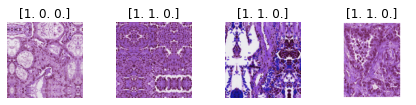

In [14]:
# check if the dataloader works
check_loader = LUAD(image_list=image_path_list)

print(len(check_loader))
fig = plt.figure()

for i in range(len(check_loader)):
    #sample = check_loader[i]
    image, labels = check_loader[i]

    print(i, image.shape, labels.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    #ax.set_title(sample['labels'])
    ax.set_title(labels)
    ax.axis('off')
    #plt.imshow(sample['image'])
    plt.imshow(image)

    if i == 3:
        plt.show()
        break

In [15]:
# creatin the train dataset
train_dataset = LUAD(image_path_list,
                     transform = transforms.Compose([transforms.ToTensor(),
                                                     transforms.Resize((224, 224)),
                                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),]
                                                     ))
'''
# creating the test dataset
test_dataset = LUAD(test_list,
                    transform = transforms.Compose([transforms.ToTensor(),
                                                    transforms.Resize((224, 224)),
                                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),]
                                                    ))
'''

'\n# creating the test dataset\ntest_dataset = LUAD(test_list,\n                    transform = transforms.Compose([transforms.ToTensor(),\n                                                    transforms.Resize((224, 224)),\n                                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),]\n                                                    ))\n'

In [16]:
batch_size = 32  #128

In [17]:
# train dataloader
train_dataloader = DataLoader(train_dataset,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 0,
                              )
'''
# test dataloader
test_dataloader = DataLoader(test_dataset,
                             batch_size = batch_size,
                             shuffle = True,
                             num_workers = 0,
                             )
'''

'\n# test dataloader\ntest_dataloader = DataLoader(test_dataset,\n                             batch_size = batch_size,\n                             shuffle = True,\n                             num_workers = 0,\n                             )\n'

In [18]:
len(train_dataloader)

1134

# Creating the model

In [19]:
model = vit_LRP(pretrained=True, num_classes=3)
#print(model(torch.randn(1, 3, 224, 224)))
#model.head = nn.Linear(768, 3)

In [20]:
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (matmul1): einsum()
        (matmul2): einsum()
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
        (softmax): Softmax(dim=-1)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate=none)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (add1): Add()
      (add2): Add()
      (clone1): Clone()
      (clone2): Clone()
    

### Checking model properties

next(model.parameters()).is_cuda

model.train()

y_pred = model(torch.randn(2, 3, 224, 224).to(device))
y_pred

y_pred.argmax(axis=1)

y_p = nn.functional.softmax(y_pred, dim=-1)
y_p

y_p.argmax(axis=1)

y_pred

y_pred.shape

type(y_pred)

y_pred.argmax(axis=1)

y = np.array([[0, 1, 0], [1, 0, 1]])

torch.from_numpy(y)

y.shape

nn.CrossEntropyLoss()(y_pred, torch.from_numpy(y.argmax(axis=1)))

for i_batch, (x, y) in enumerate(test_dataloader):
  print(x.shape, y.shape)
  print(len(y.argmax(axis=1)))
  model_vit_base_patch16_224(x.to(device))

  if i_batch == 0:
    break

model_vit_base_patch16_224(torch.randn(32, 3, 224, 224)).shape

## Training and validation

In [21]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               opt: torch.optim.Optimizer,
               eval_fn = accuracy_score,
               device: torch.device = device
               ):
  
  train_loss, train_acc = 0, 0
  model.train()
  loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=False)
  for batch, (x, y) in loop:
    
    #print(f'batch: {batch}')
    #x = data['image']
    #y = data['labels']
    # send data to GPU
    x, y = x.to(device), y.to(device)

    #clear gradients
    opt.zero_grad()

    # forward pass
    model_out = model(x)
    y_pred = torch.sigmoid(model_out).round()
    #y_pred = nn.functional.softmax(model_out, dim = -1)

    # calculate loss
    #loss = loss_fn(y_pred, y.argmax(axis=1))
    loss = loss_fn(model_out, y)
    
    train_loss += loss
    #train_acc += eval_fn(y.cpu().argmax(axis=1),
    #                     y_pred.cpu().detach().numpy().argmax(axis=1))
    train_acc += eval_fn(y.cpu().detach().numpy(),
                         y_pred.cpu().detach().numpy())

    # back-prop
    loss.backward()

    # optimize
    opt.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  #print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}")
  return train_loss, train_acc

In [22]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              eval_fn = accuracy_score,
              device: torch.device = device
              ):
  test_loss, test_acc = 0, 0
  model.eval() # put model in eval mode
  
  # Turn on inference context manager
  with torch.inference_mode(): 
    for (X, y) in data_loader:

      #x = data['image']
      #y = data['labels']
      
      # Send data to GPU
      X, y = X.to(device), y.to(device)
      
      # 1. Forward pass
      test_pred = nn.functional.softmax(model(X), dim = -1)
      
      # 2. Calculate loss and accuracy
      test_loss += loss_fn(test_pred, y.argmax(axis=1))
      test_acc += eval_fn(y.cpu().argmax(axis=1), test_pred.cpu().detach().numpy().argmax(axis=1))
      
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}\n")
    return test_loss, test_acc

In [23]:
model_save_path = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/cutmix_hila_vit_base_patch16_224_01.pth'

In [24]:
epochs = 25

In [25]:
valid_acc = -np.inf

In [26]:
for epoch in tqdm(range(epochs)):

  print(f"Epoch: {epoch+1} / {epochs}\n---------")
  ep_t_loss, ep_t_acc = train_step(data_loader=train_dataloader,
                                   model=model,
                                   loss_fn=nn.CrossEntropyLoss(),
                                   #opt=SGD(model_vit_base_patch16_224.parameters(), lr=0.00001),
                                   opt=Adam(model.parameters(), lr=0.00001),
                                   eval_fn=accuracy_score
                                   )
  
  print(f"Train loss: {ep_t_loss:.5f} | Train accuracy: {ep_t_acc:.5f}")
  # validation named as test step
  '''
  ep_v_loss, ep_v_acc = test_step(data_loader=test_dataloader,
                                  model=model,
                                  loss_fn=nn.CrossEntropyLoss(),
                                  eval_fn=accuracy_score
                                  )
  
  if ep_v_acc > valid_acc:
    print(f"accuracy increased from {valid_acc} to {ep_v_acc} saving model to: {model_save_path}")
    torch.save(obj = model_vit_base_patch16_224.state_dict(),
               f = model_save_path)
    valid_acc = ep_v_acc
  '''

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 / 25
---------


  0%|          | 0/1134 [00:00<?, ?it/s]

Train loss: 1.22337 | Train accuracy: 0.68371
Epoch: 2 / 25
---------


  0%|          | 0/1134 [00:00<?, ?it/s]

Train loss: 1.09931 | Train accuracy: 0.77628
Epoch: 3 / 25
---------


  0%|          | 0/1134 [00:00<?, ?it/s]

Train loss: 1.05026 | Train accuracy: 0.82621
Epoch: 4 / 25
---------


  0%|          | 0/1134 [00:00<?, ?it/s]

Train loss: 1.02214 | Train accuracy: 0.86371
Epoch: 5 / 25
---------


  0%|          | 0/1134 [00:00<?, ?it/s]

Train loss: 1.00317 | Train accuracy: 0.89041
Epoch: 6 / 25
---------


  0%|          | 0/1134 [00:00<?, ?it/s]

Train loss: 0.98899 | Train accuracy: 0.91507
Epoch: 7 / 25
---------


  0%|          | 0/1134 [00:00<?, ?it/s]

Train loss: 0.98217 | Train accuracy: 0.93530
Epoch: 8 / 25
---------


  0%|          | 0/1134 [00:00<?, ?it/s]

Train loss: 0.97583 | Train accuracy: 0.94615
Epoch: 9 / 25
---------


  0%|          | 0/1134 [00:00<?, ?it/s]

Train loss: 0.97135 | Train accuracy: 0.95381
Epoch: 10 / 25
---------


  0%|          | 0/1134 [00:00<?, ?it/s]

Train loss: 0.96902 | Train accuracy: 0.96079
Epoch: 11 / 25
---------


  0%|          | 0/1134 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [27]:
torch.save(obj = model.state_dict(), f = model_save_path)